## Character-level recurrent sequence-to-sequence model

Example from https://keras.io/examples/nlp/lstm_seq2seq/  
Older post https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

In [1]:
import numpy as np
import pandas as pd
from itertools import chain
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
#from keras.utils import plot_model

In [2]:
pairs = pd.read_csv("data/ncbi_02/RAxML/pairs.csv")
sgenes = pd.read_csv("data/ncbi_02/ncbi_sgene_good_unique_aligned_cleaned.csv")

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8076518382553540246
]


## Data prep

In [28]:
len(pairs)

4368

In [6]:
num_pairs = 100      # Number of samples to train on.
# num_pairs = len(pairs)
num_pairs

100

In [7]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

In [8]:
for index, pair in pairs.iterrows():
    
    if index == num_pairs:
        break
    
    parent_sgene = sgenes[sgenes["accession"]==pair["parent"]]["sgene_nucleotide"].values[0]
    child_sgene = sgenes[sgenes["accession"]==pair["child"]]["sgene_nucleotide"].values[0]
    
    input_texts.append(parent_sgene)
    target_texts.append(child_sgene)

input_characters = set(chain.from_iterable(input_texts))
target_characters = set(chain.from_iterable(target_texts))

In [9]:
print("input_texts ", len(input_texts))
print("target_texts", len(target_texts))
print("input_characters", len(input_characters), input_characters)
print("target_characters", len(target_characters), target_characters)

input_texts  100
target_texts 100
input_characters 4 {'T', 'A', 'G', 'C'}
target_characters 4 {'T', 'A', 'G', 'C'}


In [10]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

Number of samples: 100
Number of unique input tokens: 4
Number of unique output tokens: 4
Max sequence length for inputs: 3822
Max sequence length for outputs: 3822


In [11]:
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])
print("input_token_index", len(input_token_index), input_token_index)
print("target_token_index", len(target_token_index), target_token_index)

input_token_index 4 {'A': 0, 'C': 1, 'G': 2, 'T': 3}
target_token_index 4 {'A': 0, 'C': 1, 'G': 2, 'T': 3}


In [12]:
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
print("encoder_input_data.shape", encoder_input_data.shape)
print("decoder_input_data.shape", decoder_input_data.shape)
print("decoder_target_data.shape", decoder_target_data.shape)

encoder_input_data.shape (100, 3822, 4)
decoder_input_data.shape (100, 3822, 4)
decoder_target_data.shape (100, 3822, 4)


In [13]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    
    for t, char in enumerate(target_text):
        
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0

In [14]:
input_texts[0]

'ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTGTTAATCTTACAACCAGAACTCAATTACCCCCTGCATACACTAATTCTTTCACACGTGGTGTTTATTACCCTGACAAAGTTTTCAGATCCTCAGTTTTACATTCAACTCAGGACTTGTTCTTACCTTTCTTTTCCAATGTTACTTGGTTCCATGCTATACATGTCTCTGGGACCAATGGTACTAAGAGGTTTGATAACCCTGTCCTACCATTTAATGATGGTGTTTATTTTGCTTCCACTGAGAAGTCTAACATAATAAGAGGCTGGATTTTTGGTACTACTTTAGATTCGAAGACCCAGTCCCTACTTATTGTTAATAACGCTACTAATGTTGTTATTAAAGTCTGTGAATTTCAATTTTGTAATGATCCATTTTTGGGTGTTTATTACCACAAAAACAACAAAAGTTGGATGGAAAGTGAGTTCAGAGTTTATTCTAGTGCGAATAATTGCACTTTTGAATATGTCTCTCAGCCTTTTCTTATGGACCTTGAAGGAAAACAGGGTAATTTCAAAAATCTTAGGGAATTTGTGTTTAAGAATATTGATGGTTATTTTAAAATATATTCTAAGCACACGCCTATTAATTTAGTGCGTGATCTCCCTCAGGGTTTTTCGGCTTTAGAACCATTGGTAGATTTGCCAATAGGTATTAACATCACTAGGTTTCAAACTTTACTTGCTTTACATAGAAGTTATTTGACTCCTGGTGATTCTTCTTCAGGTTGGACAGCTGGTGCTGCAGCTTATTATGTGGGTTATCTTCAACCTAGGACTTTTCTATTAAAATATAATGAAAATGGAACCATTACAGATGCTGTAGACTGTGCACTTGACCCTCTCTCAGAAACAAAGTGTACGTTGAAATCCTTCACTGTAGAAAAAGGAATCTATCAAACTTCTAACTTTAGAGTCCAACCAACAGAATCTATTGTTAGATTTCCTAATATTACA

In [15]:
y_true = encoder_input_data[0]
y_true

array([[1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

In [16]:
y_pred = decoder_input_data[0]
y_pred

array([[1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

In [17]:
decoder_target_data[0]

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32)

In [18]:
keras.losses.CategoricalCrossentropy()(y_true, y_pred).numpy()

1.192093e-07

## Construct model

In [19]:
latent_dim = 64      # Latent dimensionality of the encoding space.
batch_size = 32       # Batch size for training.
epochs = 1000         # Number of epochs to train for.

In [22]:
# Define an input sequence and process it.
encoder_inputs = keras.Input(shape = (None, num_encoder_tokens))
encoder = keras.layers.LSTM(latent_dim, return_state = True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = keras.Input(shape = (None, num_decoder_tokens))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences = True, return_state = True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state = encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation = "softmax")
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [23]:
#plot_model(model, to_file = 'model.png')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, 64), (None,  17664       input_3[0][0]                    
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, None, 64), ( 17664       input_4[0][0]                    
                                                                 lstm_2[0][1]               

## Train model

In [24]:
model.compile(
    optimizer = "rmsprop", loss = "categorical_crossentropy", metrics = ["accuracy"]
)

es = EarlyStopping(monitor='val_loss', min_delta = 0, patience = 10, verbose = 1, restore_best_weights = True)

log = model.fit(
    [ encoder_input_data, decoder_input_data ],
    decoder_target_data,
    batch_size = batch_size,
    epochs = epochs,
    callbacks = [ es ],
    validation_split = 0.2,
)

Epoch 1/1000
3/3 [==============================] - 9s 2s/step - loss: 1.3828 - accuracy: 0.2810 - val_loss: 1.3600 - val_accuracy: 0.3328
Epoch 2/1000
3/3 [==============================] - 6s 2s/step - loss: 1.3558 - accuracy: 0.3327 - val_loss: 1.3499 - val_accuracy: 0.3321
Epoch 3/1000
3/3 [==============================] - 6s 2s/step - loss: 1.3503 - accuracy: 0.3344 - val_loss: 1.3474 - val_accuracy: 0.3328
Epoch 4/1000
3/3 [==============================] - 6s 2s/step - loss: 1.3469 - accuracy: 0.3332 - val_loss: 1.3453 - val_accuracy: 0.3372
Epoch 5/1000
3/3 [==============================] - 6s 2s/step - loss: 1.3449 - accuracy: 0.3368 - val_loss: 1.3440 - val_accuracy: 0.3334
Epoch 6/1000
3/3 [==============================] - 6s 2s/step - loss: 1.3445 - accuracy: 0.3407 - val_loss: 1.3451 - val_accuracy: 0.3547
Epoch 7/1000
3/3 [==============================] - 6s 2s/step - loss: 1.3430 - accuracy: 0.3479 - val_loss: 1.3407 - val_accuracy: 0.3484
Epoch 8/1000
3/3 [=========

3/3 [==============================] - 6s 2s/step - loss: 1.2989 - accuracy: 0.3751 - val_loss: 1.3061 - val_accuracy: 0.3742
Epoch 60/1000
3/3 [==============================] - 6s 2s/step - loss: 1.3011 - accuracy: 0.3724 - val_loss: 1.2961 - val_accuracy: 0.3712
Epoch 61/1000
3/3 [==============================] - 6s 2s/step - loss: 1.2963 - accuracy: 0.3735 - val_loss: 1.2964 - val_accuracy: 0.3760
Epoch 62/1000
3/3 [==============================] - 6s 2s/step - loss: 1.2976 - accuracy: 0.3721 - val_loss: 1.2959 - val_accuracy: 0.3726
Epoch 63/1000
3/3 [==============================] - 6s 2s/step - loss: 1.2960 - accuracy: 0.3725 - val_loss: 1.2993 - val_accuracy: 0.3703
Epoch 64/1000
3/3 [==============================] - 6s 2s/step - loss: 1.2955 - accuracy: 0.3762 - val_loss: 1.2916 - val_accuracy: 0.3743
Epoch 65/1000
3/3 [==============================] - 6s 2s/step - loss: 1.2925 - accuracy: 0.3757 - val_loss: 1.3021 - val_accuracy: 0.3723
Epoch 66/1000
3/3 [===============

3/3 [==============================] - 6s 2s/step - loss: 1.2567 - accuracy: 0.4135 - val_loss: 1.2605 - val_accuracy: 0.4074
Epoch 118/1000
3/3 [==============================] - 6s 2s/step - loss: 1.2627 - accuracy: 0.4036 - val_loss: 1.2574 - val_accuracy: 0.4163
Epoch 119/1000
3/3 [==============================] - 6s 2s/step - loss: 1.2609 - accuracy: 0.4097 - val_loss: 1.2558 - val_accuracy: 0.4106
Epoch 120/1000
3/3 [==============================] - 6s 2s/step - loss: 1.2592 - accuracy: 0.4073 - val_loss: 1.2503 - val_accuracy: 0.4160
Epoch 121/1000
3/3 [==============================] - 6s 2s/step - loss: 1.2499 - accuracy: 0.4174 - val_loss: 1.2508 - val_accuracy: 0.4192
Epoch 122/1000
3/3 [==============================] - 5s 2s/step - loss: 1.2574 - accuracy: 0.4106 - val_loss: 1.2519 - val_accuracy: 0.4080
Epoch 123/1000
3/3 [==============================] - 6s 2s/step - loss: 1.2516 - accuracy: 0.4146 - val_loss: 1.2516 - val_accuracy: 0.4189
Epoch 124/1000
3/3 [========

3/3 [==============================] - 6s 2s/step - loss: 1.2140 - accuracy: 0.4478 - val_loss: 1.2250 - val_accuracy: 0.4374
Epoch 176/1000
3/3 [==============================] - 6s 2s/step - loss: 1.2128 - accuracy: 0.4467 - val_loss: 1.2096 - val_accuracy: 0.4488
Epoch 177/1000
3/3 [==============================] - 5s 2s/step - loss: 1.2112 - accuracy: 0.4487 - val_loss: 1.2187 - val_accuracy: 0.4445
Epoch 178/1000
3/3 [==============================] - 5s 2s/step - loss: 1.2185 - accuracy: 0.4413 - val_loss: 1.2024 - val_accuracy: 0.4597
Epoch 179/1000
3/3 [==============================] - 5s 2s/step - loss: 1.2012 - accuracy: 0.4615 - val_loss: 1.2100 - val_accuracy: 0.4500
Epoch 180/1000
3/3 [==============================] - 6s 2s/step - loss: 1.2062 - accuracy: 0.4541 - val_loss: 1.2113 - val_accuracy: 0.4488
Epoch 181/1000
3/3 [==============================] - 5s 2s/step - loss: 1.2233 - accuracy: 0.4401 - val_loss: 1.1927 - val_accuracy: 0.4654
Epoch 182/1000
3/3 [========

3/3 [==============================] - 6s 2s/step - loss: 1.1617 - accuracy: 0.4838 - val_loss: 1.2141 - val_accuracy: 0.4477
Epoch 234/1000
3/3 [==============================] - 6s 2s/step - loss: 1.1835 - accuracy: 0.4689 - val_loss: 1.1643 - val_accuracy: 0.4855
Epoch 235/1000
3/3 [==============================] - 6s 2s/step - loss: 1.1661 - accuracy: 0.4822 - val_loss: 1.1539 - val_accuracy: 0.4904
Epoch 236/1000
3/3 [==============================] - 6s 2s/step - loss: 1.1530 - accuracy: 0.4907 - val_loss: 1.1718 - val_accuracy: 0.4669
Epoch 237/1000
3/3 [==============================] - 6s 2s/step - loss: 1.1702 - accuracy: 0.4731 - val_loss: 1.1530 - val_accuracy: 0.4893
Epoch 238/1000
3/3 [==============================] - 6s 2s/step - loss: 1.1563 - accuracy: 0.4866 - val_loss: 1.1610 - val_accuracy: 0.4845
Epoch 239/1000
3/3 [==============================] - 6s 2s/step - loss: 1.1694 - accuracy: 0.4751 - val_loss: 1.1806 - val_accuracy: 0.4747
Epoch 240/1000
3/3 [========

3/3 [==============================] - 6s 2s/step - loss: 1.1569 - accuracy: 0.4856 - val_loss: 1.1190 - val_accuracy: 0.5040
Epoch 292/1000
3/3 [==============================] - 5s 2s/step - loss: 1.1263 - accuracy: 0.5043 - val_loss: 1.1073 - val_accuracy: 0.5177
Epoch 293/1000
3/3 [==============================] - 5s 2s/step - loss: 1.1156 - accuracy: 0.5088 - val_loss: 1.1072 - val_accuracy: 0.5098
Epoch 294/1000
3/3 [==============================] - 5s 2s/step - loss: 1.0989 - accuracy: 0.5183 - val_loss: 1.1052 - val_accuracy: 0.5144
Epoch 295/1000
3/3 [==============================] - 5s 2s/step - loss: 1.1134 - accuracy: 0.5059 - val_loss: 1.1290 - val_accuracy: 0.5026
Epoch 296/1000
3/3 [==============================] - 6s 2s/step - loss: 1.1221 - accuracy: 0.5096 - val_loss: 1.1101 - val_accuracy: 0.5161
Epoch 297/1000
3/3 [==============================] - 6s 2s/step - loss: 1.1162 - accuracy: 0.5100 - val_loss: 1.1003 - val_accuracy: 0.5176
Epoch 298/1000
3/3 [========

3/3 [==============================] - 6s 2s/step - loss: 1.0780 - accuracy: 0.5300 - val_loss: 1.0978 - val_accuracy: 0.5128
Epoch 350/1000
3/3 [==============================] - 6s 2s/step - loss: 1.0751 - accuracy: 0.5293 - val_loss: 1.0585 - val_accuracy: 0.5396
Epoch 351/1000
3/3 [==============================] - 6s 2s/step - loss: 1.0543 - accuracy: 0.5436 - val_loss: 1.0589 - val_accuracy: 0.5420
Epoch 352/1000
3/3 [==============================] - 6s 2s/step - loss: 1.0673 - accuracy: 0.5362 - val_loss: 1.0534 - val_accuracy: 0.5494
Epoch 353/1000
3/3 [==============================] - 6s 2s/step - loss: 1.0481 - accuracy: 0.5475 - val_loss: 1.0641 - val_accuracy: 0.5405
Epoch 354/1000
3/3 [==============================] - 6s 2s/step - loss: 1.0817 - accuracy: 0.5273 - val_loss: 1.0787 - val_accuracy: 0.5310
Epoch 355/1000
3/3 [==============================] - 6s 2s/step - loss: 1.0809 - accuracy: 0.5260 - val_loss: 1.0785 - val_accuracy: 0.5325
Epoch 356/1000
3/3 [========

3/3 [==============================] - 4s 1s/step - loss: 1.0315 - accuracy: 0.5590 - val_loss: 1.0740 - val_accuracy: 0.5283
Epoch 408/1000
3/3 [==============================] - 4s 1s/step - loss: 1.0416 - accuracy: 0.5489 - val_loss: 0.9972 - val_accuracy: 0.5760
Epoch 409/1000
3/3 [==============================] - 4s 1s/step - loss: 0.9963 - accuracy: 0.5776 - val_loss: 1.0336 - val_accuracy: 0.5552
Epoch 410/1000
3/3 [==============================] - 4s 1s/step - loss: 1.0521 - accuracy: 0.5445 - val_loss: 1.0227 - val_accuracy: 0.5598
Epoch 411/1000
3/3 [==============================] - 4s 1s/step - loss: 1.0145 - accuracy: 0.5633 - val_loss: 1.0055 - val_accuracy: 0.5682
Epoch 412/1000
3/3 [==============================] - 4s 1s/step - loss: 1.0001 - accuracy: 0.5732 - val_loss: 1.0046 - val_accuracy: 0.5700
Epoch 413/1000
3/3 [==============================] - 4s 1s/step - loss: 1.0182 - accuracy: 0.5654 - val_loss: 1.0207 - val_accuracy: 0.5628
Epoch 414/1000
3/3 [========

In [26]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 8)

# Save model
# model.save("data/ncbi_02/model")

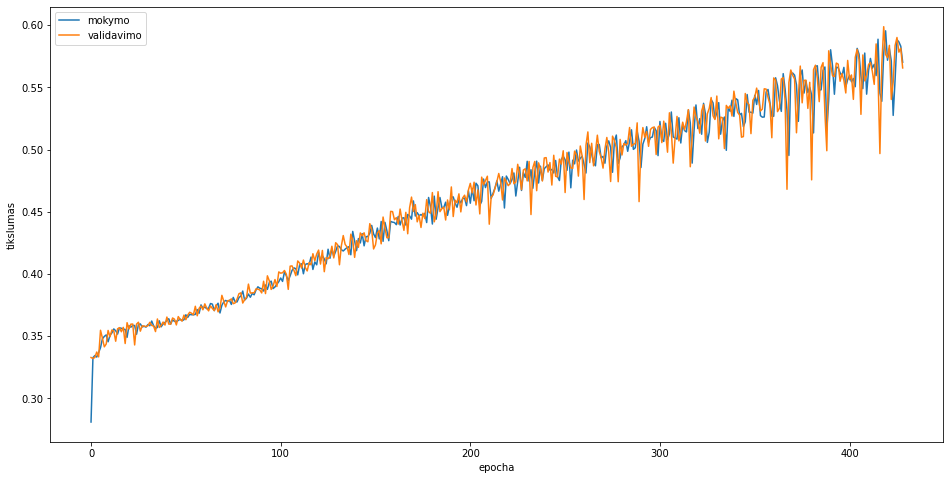

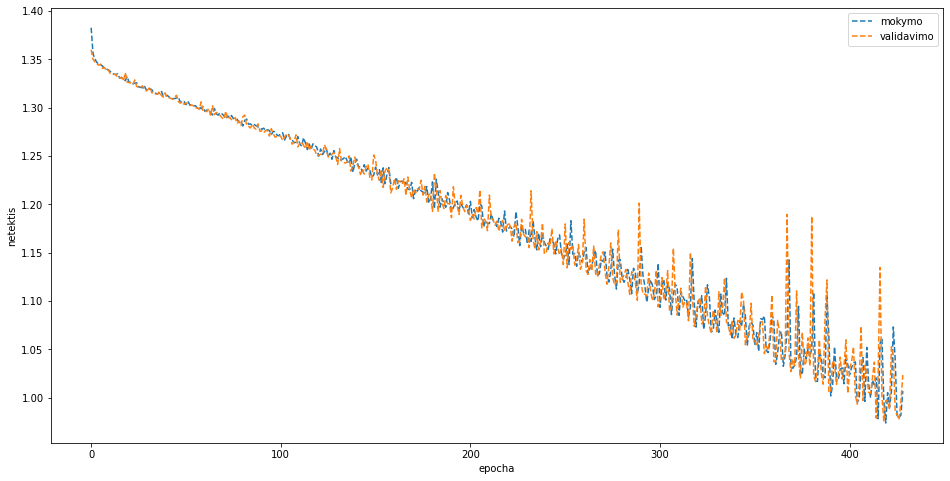

In [27]:

plt.plot(log.history['accuracy'], label = 'mokymo')
plt.plot(log.history['val_accuracy'], label = 'validavimo')
plt.ylabel('tikslumas')
plt.xlabel('epocha')
plt.legend()
plt.show()

plt.plot(log.history['loss'], '--', label = 'mokymo')
plt.plot(log.history['val_loss'], '--', label = 'validavimo')
plt.ylabel('netektis')
plt.xlabel('epocha')
plt.legend()
plt.show()


## Inference

In [ ]:
# Define sampling models
# Restore the model and construct the encoder and decoder.
model = keras.models.load_model("data/ncbi/raxml")

In [ ]:
encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(latent_dim,))
decoder_state_input_c = keras.Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]
    return decoded_sentence

In [ ]:
# for seq_index in range(20):
#     # Take one sequence (part of the training set)
#     # for trying out decoding.
#     input_seq = encoder_input_data[seq_index : seq_index + 1]
#     decoded_sentence = decode_sequence(input_seq)
#     print("-")
#     print("Input sentence:", input_texts[seq_index])
#     print("Decoded sentence:", decoded_sentence)